# Apophis Approach 2029


This notebook contains all the required code to reproduce the results and figures in the paper:

- Vallejo, Zuluaga and Chaparro, Conditions for visual and high-resolution  bistatic radar observations of Apophis in 2029.

## Environment and preparation

This section is intended to prepare the execution environment.  If running in colab, and want to 

### Required packages

In [1]:
#Evaluate if we are in Colab
try:
    import google.colab
    COLAB = True
    python="python" # In colab
except:
    COLAB = False

import sys
python=sys.executable

# Install packages
!$python -m pip install astroquery cartopy

# Get complimentary data
if COLAB:
    !git clone http://github.com/seap-udea/Apophis2029.git
    !ln -s Apophis2029/data

fatal: destination path 'Apophis2029' already exists and is not an empty directory.
ln: failed to create symbolic link './data': File exists


## Libraries and useful routines

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun
import astropy.units as u
import datetime
import dateutil.parser as dparser
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pylab import cm

#Parameters
mpl.rcParams['font.family'] = 'Latin Modern Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

#Constantes
DATADIR="data/"
FIGDIR="data/figures/"

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    (Taken from https://coderedirect.com/questions/214576/arrow-on-a-line-plot-with-matplotlib)
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

def rotation(ax,N,R,dth):
    line = ax.plot(np.linspace(0,dth,N,endpoint=True),np.ones(N)*R,'b-',lw=2)
    return line

def xaxis():
    """
    Generic function to create the appropriate x axis with the times and such
    """
    xticks = range(6,len(ephemeris),24)
    plt.xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    plt.xticks([ephemeris['hours'][i] for i in xticks],
                [ephemeris['datetime_str'][i][-5:] for i in xticks], size=16)

## Get the ephemeris

Please explain here.

In [3]:
AU = (1*u.au).to(u.m).value
t_ini = Time('2029-04-13 13:30:00',format='iso')
t_max = Time('2029-04-13 22:05:00',format='iso')
t_end = Time('2029-04-14 06:06:00',format='iso')
epochs = {'start':t_ini.value, 'stop':t_end.value, 'step':'5m'}
apophis = Horizons(id='99942',epochs=epochs) 
ephemeris = apophis.ephemerides()
vectors = apophis.vectors()
ECUcoords = SkyCoord(ephemeris['RA'], ephemeris['DEC']
                     ,ephemeris['delta'], frame='gcrs')
vectors['delta (Rt)'] = ephemeris['delta']*u.au.to(u.R_earth)
vectors.to_pandas().to_csv("data/ephemeris.csv")

## Get Data

In [11]:
vectors = pd.read_csv(f"{DATADIR}/vectors2.csv")
ephemeris = pd.read_csv(f"{DATADIR}/ephemeris2.csv")
ephemeris['hours'] = 24*(ephemeris['datetime_jd']-ephemeris['datetime_jd'][0])
maxlons = np.loadtxt(f"{DATADIR}/maxlons.txt")
maxlats = np.loadtxt(f"{DATADIR}/maxlats.txt")
deltas = np.loadtxt(f"{DATADIR}/deltas.txt")
radio = pd.read_excel(f"{DATADIR}/AllRadiotelescopes2.xlsx").dropna(how='all')
MIN = ephemeris['delta (Rt)'].argmin()

FileNotFoundError: ignored

## Basic plots

### Polar distance plot

Please explain.

findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.


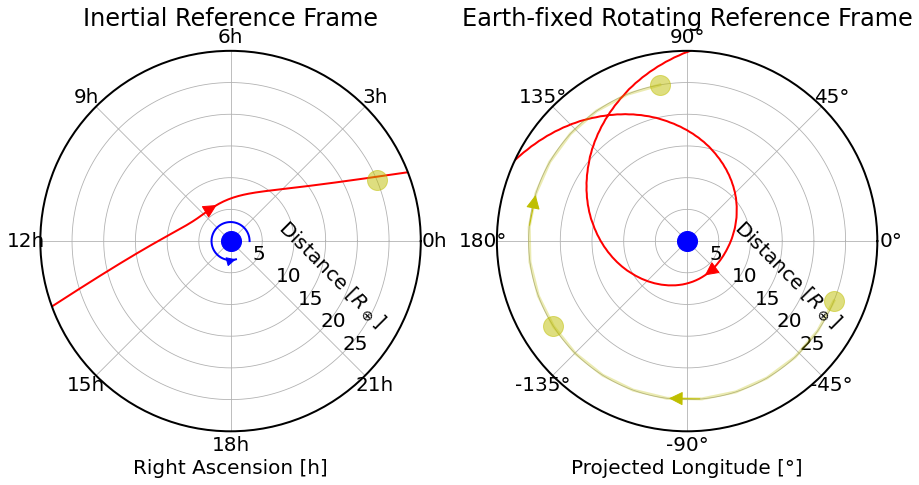

In [5]:
def get_lon(TIME,RA):
  """
  Gets the longitude that will be under the asteroid at every moment
  """
  T = Time(TIME,format='jd')
  G = T.sidereal_time('apparent', 'greenwich').to(u.deg)
  return RA - G.value

sun = get_lon(ephemeris['datetime_jd'][::10],1.5*15)
for i in range(len(sun)):
   if sun[i] < -180: sun[i] += 360

sun = np.deg2rad(sun)

fig, (ax1,ax2) = plt.subplots(1,2,subplot_kw={'projection': 'polar'},figsize=(15,8))

def polar(ax,key,ylabel,title):
    line = ax.plot(np.deg2rad(ephemeris[key]),ephemeris['delta (Rt)'],'r-',lw=2)[0]
    ax.set_xlabel(ylabel)
    ax.set_yticks([5,10,15,20,25])
    ax.text(-1.4*np.pi/4,15,"Distance [$R_\oplus$]",rotation=-45)
    ax.set_ylim([0,30])
    ax.set_rlabel_position(315)
    if key == 'RA':
        ax.set_xticklabels([f"{s}h" for s in range(0,25,3)])
        arrow = rotation(ax,100,3,5)[0]
        add_arrow(arrow,size=20,position=4.95)
        ax.plot(np.deg2rad(1.5*15),25,'yo',ms=20, alpha=0.5)
    else:
        angle = lambda x: x if x<= 180 else x - 360
        ax.set_xticklabels([f"{angle(s)}°" for s in range(0,360,45)])
        N = len(sun)
        for n in [0,N//2,N-1]:
            ax.plot(sun[n],25,'yo',ms=20, alpha=0.5)
        sun_path = ax.plot(sun,sun*0+25,'y-', alpha=0.3, lw=3)[0]
        add_arrow(sun_path,size=30, position=np.pi)
        add_arrow(sun_path,size=30, position=-np.pi/2)


    ax.set_title(title)
    ax.plot(0,0,'bo',ms=20)
    add_arrow(line,size=30)

polar(ax1,'RA','Right Ascension [h]','Inertial Reference Frame')
polar(ax2,'Longitude',"Projected Longitude [°]",'Earth-fixed Rotating Reference Frame')

name = f"{FIGDIR}/distance"
plt.savefig(name+".pdf",bbox_inches='tight')

### Magnitude plot

Please explain.

findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.


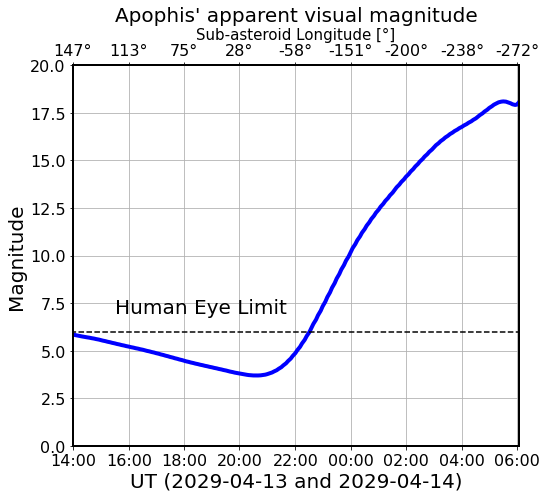

In [6]:
fig,ax = plt.subplots(figsize=(8,7))
ax.set_title(f"Apophis' apparent visual magnitude",size=20)

poly = np.polyfit(range(200),ephemeris['V'], deg=20)
p = np.poly1d(poly)
V = p(range(200))

ax.plot(ephemeris['hours'],V,'b-',lw=4)
ax.set_xlabel("UT (2029-04-13 and 2029-04-14)")
ax.set_ylabel("Magnitude")
ax.text(ephemeris['hours'][0]+2,7,"Human Eye Limit",size=20)
ax.grid()
xaxis()

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Sub-asteroid Longitude [°]',size=15)

xticks = range(6,len(ephemeris),24)
secax.set_xticks([ephemeris['hours'][i] for i in xticks])
secax.set_xticklabels([f"{round(ephemeris['Longitude'][i])}°" for i in xticks], size=16)


plt.yticks(size=16)
plt.ylim([0,20])

plt.plot([-10,100],[6,6],'k--')

name = f"{FIGDIR}/magnitude"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

### Observatory pairs

Please explain.

In [10]:
radio.Code

0     ARE
1     GOL
2     GBI
3     GBT
4     G1F
5     VLA
6     VLB
7     FAS
8     CDS
9     ECD
10    TSU
11    USU
12    GRE
13    OKI
14    MAS
15    KAT
16    BIS
17    KAM
18    UCH
Name: Code, dtype: object

In [8]:
emitting = ['CDS','MDS','ARE','GOL','ECD','USU']
receiving = ['PRK','LOV','EFE','AVN','GBT','VLA','FAS']

emitting = [radio[radio.Code == a].iloc[0] for a in emitting]
receiving = [radio[radio.Code == a].iloc[0] for a in receiving]

def axes(ax,i):
    ax.set_ylim([0,90])
    ax.set_xlim([0,ephemeris['hours'].iloc[-1]])
    xticks = range(6,len(ephemeris),24)
    ax.set_xlim([ephemeris['hours'].iloc[6],ephemeris['hours'].iloc[-1]])
    ax.set_xticks([ephemeris['hours'][i] for i in xticks])
    yticks = list(range(0,91,15))
    ax.set_yticks(yticks)
    ax.set_yticklabels(["%i°"%h for h in yticks])
    ax.set_ylabel("Elevation (°)",size=16)
    ax.set_xticklabels([ephemeris['datetime_str'][i][-5:] for i in xticks],size=16)

    if i == 1:
        ax.set_xlabel("UT (2029-04-13 and 2029-04-14)",size=16)


fig, axs = plt.subplots(2,1, figsize=(20,10))
styles = ['-',':','*-','s-','-.','v-','o-','--','D-']
colors = ['#4287f5','#2bb516','#e89b15','#ff0000']

for i,antennae in enumerate([emitting,receiving]):
    ax = axs.flat[i]

    for j,obs1 in enumerate(antennae):
        cs = int(float(obs1.Stage)) - 1
        obs_data = utils.single_elevation(obs1,ephemeris)
        ax.plot(ephemeris['hours'],obs_data['elevation1'],
            styles[j],label=f"{obs1['Name']}",lw=3,color=colors[cs],
            markevery=10, ms=10)
        axes(ax,i)

    for tt,t in enumerate(range(30,len(ephemeris),48)):
        ax.text(ephemeris['hours'][t]-0.5, 80, f"Stage {tt+1}")

    ax.legend(fontsize=12, loc="center right")
    ax.grid()

axs[0].set_title("a) Emitting Antennae",size=18)
axs[1].set_title("b) Receiving Antennae",size=18)

fig.suptitle("Observation Plan Around Closest Approach")

name = f"{FIGDIR}/observing-plan"
plt.savefig(name+".pdf",bbox_inches='tight')

IndexError: ignored

## Plot approach

In [ ]:
def draw(ax,t,i,text=False,arrow=False):
    labels = list('abcdefghi')
    ax.set_global()
    ax.stock_img()

    print(ephemeris['datetime_str'][t])
    date = dparser.parse(ephemeris['datetime_str'][t].replace("A.D. ",""))
    ax.add_feature(Nightshade(date, alpha=0.2))
    ax.set_title(
        "Stages of 99942 Apophis Trajectory \n {}".format(
        str(ephemeris['datetime_str'][t])),
        size=20)

    plt.plot(maxlons,maxlats,'r-',lw=5,transform=data_crs)
    plt.plot(maxlons[t],maxlats[t],'ro',ms=15,transform=data_crs)

    plt.plot(maxlons,maxlats,'w-',lw=2,transform=data_crs)
    plt.plot(maxlons[t],maxlats[t],'wo',ms=12,transform=data_crs)

    for r,row in radio.iterrows():
        if not np.isnan(row.Power):
            plt.plot(row.Longitude,row.Latitude,'b*',ms=15,transform=data_crs,label=f"{row.Stage} "+row.Name)
        else:
            plt.plot(row.Longitude,row.Latitude,'bo',ms=10,transform=data_crs,label=f"{row.Stage} "+row.Name)
        if text:
            dx,dy = row[['dx','dy']]
            plt.text(
                row.Longitude+dx,row.Latitude+dy-1,
                row.Stage,transform=data_crs,fontsize=15)#,rotation=30)
    plt.legend(loc=3,prop={'size': 15})

    di = 0
    rot = [0, -30, 0, 5]
    dys = [0, -2, 10, -5]
    dxs = [25,0,50,10]
    f = int(len(maxlats)/4.5)
    for i in [1,2,3,4]:
        plt.text(maxlons[i*f] + dxs[i-1],maxlats[i*f] + dys[i-1],
        f"Stage {i+di}",size=20,color='black',
        transform=data_crs, rotation=rot[i-1])

data_crs = ccrs.Geodetic()

t = ephemeris['delta (Rt)'].idxmin()
# t = int(0.93*len(ephemeris))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
draw(ax,t,0,True)

name = f"{FIGDIR}/map"
plt.savefig(name+".pdf",bbox_inches='tight')
plt.savefig(name+".png",bbox_inches='tight')

In [14]:
!make -C Apophis2029 pull

make: Entering directory '/content/Apophis2029'
Getting the lattest changes
HEAD is now at ca0171f Commit
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 2), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), done.
From http://github.com/seap-udea/Apophis2029
   ca0171f..dad9d42  main       -> origin/main
Updating ca0171f..dad9d42
Fast-forward
 ApproachingPlots.ipynb | 2 +-
 data/figures/.dir      | 0
 2 files changed, 1 insertion(+), 1 deletion(-)
 create mode 100644 data/figures/.dir
make: Leaving directory '/content/Apophis2029'


In [17]:
!ls data

ephemeris.csv
